# Professional Athlete Classifier Using Azure Machine Learning Service 

The following tutorial demonstrates an end-to-end workflow for training and deploying a **Tensorflow 2.0** model on Azure Machine Learning Service. The notebook will cover the following topics:

- Azure Machine Learning service workspace and basic concepts
- Creating a dataset using Azure Cognitive Services and hosting it on a blob datastore
- Setting up an auto-scaling AML Compute cluster
- Training a distributed model across multiple nodes and GPUs
- Deploying a model and creating a web service endpoint


## Problem Statement

Professional sporting events have the power to bring friends, families, and co-workers together at home, at bars, and at the venue itself. While most people enjoy the social aspect and the entertainment of the game, few can recognize every single athlete that is on the court, field, or ice.

In this demo, we will be building a model that help solves this problem by classifying NBA players based upon their photo. While this can be extended to a multi-classification problem, this example will focus on a binary classification between two of the top NBA players today - Lebron James and Stephen Curry.

<table>
    <tr>
        <td>
            <h2>Lebron James</h2>
            <img src='./images/lebron.jpg' height='200' width='400'>
        </td>
        <td>
            <h2>Stephen Curry</h2>
            <img src='./images/steph.jpg' height='300' width='475'>
        </td>
    </tr>
</table>

## What is Azure Machine Learning Service?
Azure Machine Learning service is a cloud service that you can use to develop and deploy machine learning models. Using Azure Machine Learning service, you can track your models as you build, train, deploy, and manage them, all at the broad scale that the cloud provides.
![](./images/aml-overview.png)

## Prerequisites

The tutorial requires the following prerequisites:

- An existing Azure Machine Learning service workspace
- An existing notebook VM instance inside the workspace

The tutorial is designed to be run on the notebook VM instance. Click [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/tutorial-1st-experiment-sdk-setup) for instructions on creating a workspace and notebook VM.

## Connect To Workspace

The [workspace](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.workspace(class)?view=azure-ml-py) is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. The workspace holds all your experiments, compute targets, models, datastores, etc.

You can [open ml.azure.com](https://ml.azure.com) to access your workspace resources through a graphical user interface of **Azure Machine Learning studio**.

![](./images/aml-workspace.png)

**You will be asked to login in the next step. Use your Microsoft AAD credentials.**

In [1]:
from azureml.core import Workspace

workspace = Workspace.from_config()
print('Workspace name: ' + workspace.name, 
      'Azure region: ' + workspace.location, 
      'Subscription id: ' + workspace.subscription_id, 
      'Resource group: ' + workspace.resource_group, sep = '\n')

Performing interactive authentication. Please follow the instructions on the terminal.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code AY9ENUYDE to authenticate.
Interactive authentication successfully completed.
Workspace name: john-east
Azure region: eastus
Subscription id: 15ae9cb6-95c1-483d-a0e3-b1a1a3b06324
Resource group: john


## Create Dataset Using Azure Cognitive Services

[Azure Cognitive Services](https://azure.microsoft.com/en-us/services/cognitive-services/) is a comprehensive family of AI services and cognitive APIs. We will be using the [Bing Image Search API](https://azure.microsoft.com/en-us/services/cognitive-services/bing-image-search-api/) to find and download images of professional athletes in order to build a dataset that can be used for training.

![](./images/cog-services.png)

To complete this section, you will need to create an Azure Cognitive Service resource in order to obtain an API key. [Click here](https://docs.microsoft.com/en-us/azure/cognitive-services/cognitive-services-apis-create-account?tabs=multiservice%2Cwindows) for instructions on how to do so.

**Save the API key in a variable that we will use later.**

In [2]:
cognitive_service_api_key = '<API KEY HERE>'

We have prepared a script which does the following steps in sequence:

1. For each athlete, make a query to the Bing Image Search API for profile photos.
2. Download each image from the resulting response and crop out the face of the athlete.
3. Save the images to a data directory in corresponding test/valid and label folders.

**Let's take a look at the data preparation script**

In [3]:
%pycat src/cognitive-service-web-scraper.py

**Install the necessary packages to the run the script**

In [4]:
%pip install opencv-python imutils

     |████████████████████████████████| 28.7MB 21.3MB/s eta 0:00:01
  Created wheel for imutils: filename=imutils-0.5.3-cp36-none-any.whl size=25851 sha256=7b4172ccd2e5ce4d1d0a894f5b4aee97bda8424ccf0796861d25a5f96fbf2c49
  Stored in directory: /home/azureuser/.cache/pip/wheels/16/84/1f/bf88641293cda2c8be81a5c4b8ca973dd9125a6dc3767417fd
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


The script downloads images in a predefined directory. In order to make it easier for training later on, we will mount a [Blob Storage](https://azure.microsoft.com/en-us/services/storage/blobs/) container into our local directory and download the images directly into that datastore.

When an Azure Machine Learning workspace is created, a datastore is created by default.

**Get the default datastore of the workspace**

In [5]:
# Get default datastore
datastore = workspace.get_default_datastore()

**Create a blobfuse config file which is required for mounting**

In [6]:
config_file_name = 'blobfuse_connection.cfg'

config_params = 'accountName {}\naccountKey {}\ncontainerName {}'.format(
    datastore.account_name, 
    datastore.account_key, 
    datastore.container_name)

config_file = open(config_file_name, 'w')
config_file.writelines(config_params)
config_file.close()

**Create directory that will map to the Blob Storage container**

In [7]:
blobstore_dir = 'blobstore'

In [8]:
import os
if not os.path.exists(blobstore_dir):
    os.makedirs(blobstore_dir)

**Mount the datastore using blobfuse**

In [9]:
!sudo blobfuse {blobstore_dir} --tmp-path=/mnt/resource/blobfusetmp  --config-file={config_file_name} -o attr_timeout=240 -o entry_timeout=240 -o negative_timeout=120

**Now we can run the script to build our dataset**

In [10]:
data_dir = 'nba-players'

In [11]:
!sudo mkdir {blobstore_dir}/{data_dir}

mkdir: cannot create directory ‘blobstore/nba-players’: File exists


In [18]:
import sys
!sudo {sys.executable} src/cognitive-service-web-scraper.py --root_dir {blobstore_dir}/{data_dir} --image_dim 400 --api_key {cognitive_service_api_key}

Writing image 0 for Lebron James...
Writing image 1 for Lebron James...
Writing image 2 for Lebron James...
Writing image 3 for Lebron James...
Writing image 4 for Lebron James...
Writing image 5 for Lebron James...
Writing image 6 for Lebron James...
Writing image 7 for Lebron James...
Writing image 8 for Lebron James...
Writing image 9 for Lebron James...
Writing image 10 for Lebron James...
Writing image 11 for Lebron James...
Writing image 12 for Lebron James...
Writing image 13 for Lebron James...
Writing image 14 for Lebron James...
Writing image 15 for Lebron James...
Writing image 16 for Lebron James...
Writing image 17 for Lebron James...
Writing image 18 for Lebron James...
Writing image 19 for Lebron James...
Writing image 20 for Lebron James...
Writing image 21 for Lebron James...
Writing image 22 for Lebron James...
Writing image 23 for Lebron James...
Writing image 24 for Lebron James...
Writing image 25 for Lebron James...
Writing image 26 for Lebron James...
Writing ima

Writing image 210 for Lebron James...
Writing image 211 for Lebron James...
Writing image 212 for Lebron James...
Writing image 213 for Lebron James...
Writing image 214 for Lebron James...
Writing image 215 for Lebron James...
Writing image 216 for Lebron James...
Writing image 217 for Lebron James...
Writing image 218 for Lebron James...
Writing image 219 for Lebron James...
Writing image 220 for Lebron James...
Writing image 221 for Lebron James...
Writing image 222 for Lebron James...
Writing image 223 for Lebron James...
Writing image 224 for Lebron James...
Writing image 225 for Lebron James...
Writing image 226 for Lebron James...
Writing image 227 for Lebron James...
Writing image 228 for Lebron James...
Writing image 229 for Lebron James...
Writing image 230 for Lebron James...
Writing image 231 for Lebron James...
Writing image 232 for Lebron James...
Writing image 233 for Lebron James...
Writing image 234 for Lebron James...
Writing image 235 for Lebron James...
Writing imag

Writing image 414 for Lebron James...
Writing image 415 for Lebron James...
Writing image 416 for Lebron James...
Writing image 417 for Lebron James...
Writing image 418 for Lebron James...
Writing image 419 for Lebron James...
Writing image 420 for Lebron James...
Writing image 421 for Lebron James...
Writing image 422 for Lebron James...
Writing image 423 for Lebron James...
Writing image 424 for Lebron James...
Writing image 425 for Lebron James...
Writing image 426 for Lebron James...
Writing image 427 for Lebron James...
Skipping blobstore/nba-players/valid/Lebron_James/427.jpg due to download error:
Writing image 427 for Lebron James...
Writing image 428 for Lebron James...
Writing image 429 for Lebron James...
Writing image 430 for Lebron James...
Writing image 431 for Lebron James...
Writing image 432 for Lebron James...
Writing image 433 for Lebron James...
Writing image 434 for Lebron James...
Writing image 435 for Lebron James...
Writing image 436 for Lebron James...
Writing

Writing image 119 for Stephen Curry...
Writing image 120 for Stephen Curry...
Writing image 121 for Stephen Curry...
Writing image 122 for Stephen Curry...
Writing image 123 for Stephen Curry...
Writing image 124 for Stephen Curry...
Writing image 125 for Stephen Curry...
Writing image 126 for Stephen Curry...
Writing image 127 for Stephen Curry...
Writing image 128 for Stephen Curry...
Writing image 129 for Stephen Curry...
Writing image 130 for Stephen Curry...
Writing image 131 for Stephen Curry...
Writing image 132 for Stephen Curry...
Writing image 133 for Stephen Curry...
Writing image 134 for Stephen Curry...
Writing image 135 for Stephen Curry...
Writing image 136 for Stephen Curry...
Writing image 137 for Stephen Curry...
Writing image 138 for Stephen Curry...
Writing image 139 for Stephen Curry...
Writing image 140 for Stephen Curry...
Writing image 141 for Stephen Curry...
Writing image 142 for Stephen Curry...
Writing image 143 for Stephen Curry...
Writing image 144 for Ste

Writing image 323 for Stephen Curry...
Writing image 324 for Stephen Curry...
Writing image 325 for Stephen Curry...
Writing image 326 for Stephen Curry...
Writing image 327 for Stephen Curry...
Writing image 328 for Stephen Curry...
Writing image 329 for Stephen Curry...
Writing image 330 for Stephen Curry...
Writing image 331 for Stephen Curry...
Writing image 332 for Stephen Curry...
Writing image 333 for Stephen Curry...
Writing image 334 for Stephen Curry...
Writing image 335 for Stephen Curry...
Writing image 336 for Stephen Curry...
Writing image 337 for Stephen Curry...
Writing image 338 for Stephen Curry...
Writing image 339 for Stephen Curry...
Writing image 340 for Stephen Curry...
Writing image 341 for Stephen Curry...
Writing image 342 for Stephen Curry...
Writing image 343 for Stephen Curry...
Writing image 344 for Stephen Curry...
Writing image 345 for Stephen Curry...
Writing image 346 for Stephen Curry...
Writing image 347 for Stephen Curry...
Writing image 348 for Ste

Cropping image: blobstore/nba-players/train/Lebron_James/114.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/115.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/116.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/117.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/118.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/119.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/12.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/120.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/121.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/122.jpg
Premature end of JPEG file
Cropping image: blobstore/nba-players/train/Lebron_James/123.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/124.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/125.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/126.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/127.jpg

Cropping image: blobstore/nba-players/train/Lebron_James/223.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/224.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/225.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/226.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/227.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/228.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/229.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/23.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/230.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/231.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/232.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/233.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/234.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/235.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/236.jpg
Cropping image: blobstore/

Cropping image: blobstore/nba-players/train/Lebron_James/333.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/334.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/335.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/336.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/337.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/338.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/339.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/34.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/340.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/341.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/342.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/343.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/344.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/345.jpg
Cropping image: blobstore/nba-players/train/Lebron_James/346.jpg
Cropping image: blobstore/

Cropping image: blobstore/nba-players/train/Stephen_Curry/200.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/304.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/203.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/161.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/214.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/234.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/169.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/275.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/269.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/284.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/168.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/131.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/339.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/209.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/296.jpg
Cropping i

Cropping image: blobstore/nba-players/train/Stephen_Curry/331.jpg
Removing corrupted file: blobstore/nba-players/train/Stephen_Curry/331.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/226.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/229.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/130.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/155.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/147.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/235.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/306.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/135.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/151.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/167.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/326.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/340.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/294.jpg
C

Cropping image: blobstore/nba-players/train/Stephen_Curry/33.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/34.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/35.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/36.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/37.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/38.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/39.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/4.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/40.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/41.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/42.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/43.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/44.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/45.jpg
Cropping image: blobstore/nba-players/train/Stephen_Curry/46.jpg
Cropping image: blobstore/

Cropping image: blobstore/nba-players/valid/Lebron_James/398.jpg
Cropping image: blobstore/nba-players/valid/Lebron_James/399.jpg
Cropping image: blobstore/nba-players/valid/Lebron_James/400.jpg
Cropping image: blobstore/nba-players/valid/Lebron_James/401.jpg
Cropping image: blobstore/nba-players/valid/Lebron_James/402.jpg
Cropping image: blobstore/nba-players/valid/Lebron_James/403.jpg
Cropping image: blobstore/nba-players/valid/Lebron_James/404.jpg
Cropping image: blobstore/nba-players/valid/Lebron_James/405.jpg
Cropping image: blobstore/nba-players/valid/Lebron_James/406.jpg
Cropping image: blobstore/nba-players/valid/Lebron_James/407.jpg
Cropping image: blobstore/nba-players/valid/Lebron_James/408.jpg
Cropping image: blobstore/nba-players/valid/Lebron_James/409.jpg
Cropping image: blobstore/nba-players/valid/Lebron_James/410.jpg
Cropping image: blobstore/nba-players/valid/Lebron_James/411.jpg
Cropping image: blobstore/nba-players/valid/Lebron_James/412.jpg
Cropping image: blobstore

Cropping image: blobstore/nba-players/valid/Stephen_Curry/391.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/415.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/493.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/362.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/441.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/477.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/468.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/464.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/396.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/432.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/455.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/351.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/353.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/422.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/398.jpg
Cropping i

Cropping image: blobstore/nba-players/valid/Stephen_Curry/453.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/491.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/352.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/425.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/366.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/474.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/500.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/397.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/499.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/356.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/444.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/472.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/372.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/392.jpg
Cropping image: blobstore/nba-players/valid/Stephen_Curry/7.jpg
Cropping ima

## Register Dataset

Now we can register the directory in our datastore as a [Dataset](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.dataset.dataset?view=azure-ml-py), which is simply a reference to a file or folder in a storage container. Registered datasets can then be mounted to compute targets during training making it very easy to have your data be accessible on any machine during training.

In [19]:
from azureml.core import Dataset

nba_players_dataset = Dataset.File.from_files(path=(datastore, data_dir))

nba_players_dataset = nba_players_dataset.register(workspace=workspace,
                                       name='NBA Players Dataset',
                                       description='Dataset containing pictures of NBA players')

**If the dataset has already been registered, then you (and other users in your workspace) can directly run this cell to get access to it.**

In [20]:
nba_players_dataset = workspace.datasets['NBA Players Dataset']

## Create Compute Target

A [compute target](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.computetarget?view=azure-ml-py) is a designated compute resource/environment where you run your training script or host your service deployment. This location may be your local machine or a cloud-based compute resource. Compute targets can be reused across the workspace for different runs and experiments. 

For this tutorial, we will create an auto-scaling [Azure Machine Learning Compute](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.compute.amlcompute?view=azure-ml-py) cluster, which is a managed-compute infrastructure that allows the user to easily create a single or multi-node compute. To create the cluster, we need to specify the following parameters:

- `vm_size`: The is the type of GPUs that we want to use in our cluster. For this tutorial, we will use **Standard_NC6 (NVIDIA K80) GPU Machines** .
- `idle_seconds_before_scaledown`: This is the number of seconds before a node will scale down in our auto-scaling cluster. We will set this to **1200** seconds. 
- `min_nodes`: This is the minimum numbers of nodes that the cluster will have. To avoid paying for compute while they are not being used, we will set this to **0** nodes.
- `max_modes`: This is the maximum number of nodes that the cluster will scale up to. Will will set this to **2** nodes.

**When jobs are submitted to the cluster it takes approximately 5 minutes to allocate new nodes** 

In [28]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = 'k80cluster'
compute_config = AmlCompute.provisioning_configuration(vm_size='Standard_NC6',
                                                       idle_seconds_before_scaledown=1200,
                                                       min_nodes=0, 
                                                       max_nodes=2)

compute_target = ComputeTarget.create(workspace, cluster_name, compute_config)
compute_target.wait_for_completion(show_output=True)

Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


**If the compute target has already been created, then you (and other users in your workspace) can directly run this cell to get access to it.**

In [29]:
compute_target = workspace.compute_targets['k80cluster']

## Perform Experiment

Now that we have our dataset registered and compute target created, it is time to start training our model. We will start by creating an [experiment](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.experiment.experiment?view=azure-ml-py). An experiment is a grouping of many runs from a specified script. All runs in this tutorial will be performed under the same experiment. 

In [30]:
from azureml.core import Experiment

experiment_name = 'nba-player-classifier' 
experiment = Experiment(workspace, name=experiment_name)

A training script has been prepared in advance and will be used to train our model. The Tensorflow 2.0 training script adds dropout and classification layers to a base ResNet50 model and then fine-tunes the weights on our new dataset.

**Let's take a look at what the script looks like exactly**

In [24]:
%pycat src/train.py

**Next step is to create a TensorFlow Estimator**

The Azure Machine Learning Python SDK Estimator classes allow you to easily construct run configurations for your experiments. They allow you too define parameters such as the training script to run, the compute target to run it on, framework versions, additional package requirements, etc. 

You can also use a generic [Estimator](https://docs.microsoft.com/en-us/python/api/azureml-train-core/azureml.train.estimator.estimator?view=azure-ml-py) to submit training scripts that use any learning framework you choose.

For popular libaries like PyTorch and Tensorflow you can use their framework specific estimators. We will use the [TensorFlow Estimator](https://docs.microsoft.com/en-us/python/api/azureml-train-core/azureml.train.dnn.tensorflow?view=azure-ml-py) for our experiment.

In [31]:
from azureml.train.dnn import TensorFlow

estimator = TensorFlow(source_directory='src',
                      entry_script='train.py',
                      compute_target=compute_target,
                      script_params = {
                          '--data_dir': nba_players_dataset.as_named_input('nbaplayersdata').as_mount(),
                          '--image_dim': 250,
                          '--learning_rate': 0.001,
                          '--batch_size': 16,
                          '--steps_per_epoch': 100,
                          '--num_epochs': 25,
                          '--dropout_rate': 0.5,
                          '--activation_function': 'softmax',
                          '--output_dir':'./outputs',
                      },
                      framework_version='2.0',
                      use_gpu=True,
                      pip_packages=['Pillow==6.2.0', 'scipy==1.1.0', 'azureml-dataprep[fuse,pandas]==1.1.29'])

**Now we submit our estimator to the experiment**

In [32]:
run = experiment.submit(estimator)

**We can monitor the progress of our run within the notebook**

In [39]:
from azureml.widgets import RunDetails
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', '…

**Now we can register the trained model into our workspace**

In [40]:
model = run.register_model(model_name='nba-player-classifier', 
                           model_path='outputs',
                           datasets=[('train, test, validation data', nba_players_dataset)],
                           description='ResNet 50 model of for classifying NBA players')

## Deploy Model

Once we are satisified with the performance of our model, we can deploy it as a web service. For this tutorial, we will be deploying our service to an [Azure Container Instance (ACI)](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.webservice.aciwebservice?view=azure-ml-py). Azure Machine Learning has options for [local](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.webservice.localwebservice?view=azure-ml-py) and [Azure Kubernetes Service (AKS)](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.webservice.akswebservice?view=azure-ml-py) deployment as well. Deployment of a model requires the following dependencies:

- A scoring script to show how to use the model
- An environment file to show what packages need to be installed
- A configuration file to build the web service
- The model that was previously trained

The scoring script requires two methods:

- **init()**: This method is run upon deployment of the web service container. This is typically where the model is loaded.
- **run()**: This method is run each time a request is sent to the web service. This is your predict method.

**Let's take a look at the scoring script that has already been created.**

In [42]:
%pycat src/score.py

To assist with creating the environment file, we will be using the [CondaDepencies](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.conda_dependencies.condadependencies?view=azure-ml-py) class to define the required python packages for running our scoring script. 

**The code below creates the environment file that we need for deployment.**

In [43]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(conda_packages=['numpy','pandas'],
                                 pip_packages=['inference-schema[numpy-support]', 'azureml-defaults', 'tensorflow==2.0.0', 'opencv-python==4.1.1.26'])

with open('src/myenv.yml','w') as f:
    f.write(myenv.serialize_to_string())

**Let's take a look at the environment file that was created**

In [44]:
%pycat src/myenv.yml

**We define our deployment configuration using the [InferenceConfig](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.core.model.inferenceconfig?view=azure-ml-py) class.**

In [45]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(source_directory='src',
                                   runtime= 'python', 
                                   entry_script='score.py',
                                   conda_file='myenv.yml')

**Now we can create and deploy our web service (deployment will take about 10 minutes).**

In [46]:
from azureml.core.webservice import Webservice
from azureml.exceptions import WebserviceException
from azureml.core.webservice import AciWebservice, Webservice

aci_config = AciWebservice.deploy_configuration(cpu_cores=2, 
                                                memory_gb=4, 
                                                tags={'model': 'RESNET 50', 'method': 'tensorflow'}, 
                                                description='Predicts NBA player based on image')

aci_service_name = 'nba-player-aciservice'

try:
    aci_service = Webservice(workspace, name=aci_service_name)
    if aci_service:
        aci_service.delete()
except WebserviceException as e:
    print()

In [48]:
from azureml.core import Model
aci_service = Model.deploy(workspace, aci_service_name, [model], inference_config, aci_config)

aci_service.wait_for_deployment(True)
print(aci_service.state)

Running.............................
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


## Test Web Service

Once the model has been successfully deployed, we can test the web service.

**We can easily check out the HTTP endpoint of the web service.**

In [50]:
print(aci_service.scoring_uri)

http://4c282855-bcb0-425b-8093-05d83c1026cb.eastus.azurecontainer.io/score


**Send in some requests to test our service.**

In [51]:
import requests

test_images = [
    'https://a.espncdn.com/photo/2019/0603/r551314_1296x729_16-9.jpg', 
    'https://media.voltron.voanews.com/Drupal/01live-166/2019-04/00F04247-6B94-4259-AE2E-916E333E9C79.jpg'
]

predictions = []

for url in test_images:
    input_data = '{\"image_url\": \"'+ url +'\"}'
    headers = {'Content-Type':'application/json'}
    response = requests.post(aci_service.scoring_uri, input_data, headers=headers)
    predictions.append(response)

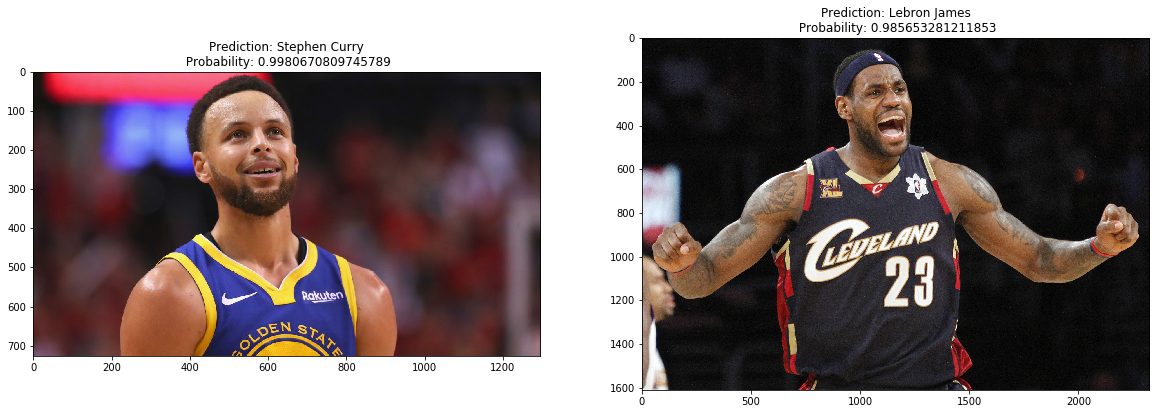

In [52]:
import json
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from matplotlib import rcParams
%matplotlib inline

labels = ['Lebron James', 'Stephen Curry']

# Download images
img_A = Image.open(BytesIO(requests.get(test_images[0]).content))
img_B = Image.open(BytesIO(requests.get(test_images[1]).content))

# Get predictions
result_A = np.array(json.loads(json.loads(predictions[0].text))['prediction'][0])
result_B = np.array(json.loads(json.loads(predictions[1].text))['prediction'][0])
prediction_A = 'Prediction: {}\n Probability: {}'.format(labels[result_A.argmax()], result_A.max())
prediction_B = 'Prediction: {}\n Probability: {}'.format(labels[result_B.argmax()], result_B.max())

# Display images
rcParams['figure.figsize'] = 20,15
fig, ax = plt.subplots(1,2)
ax[0].set_title(prediction_A)
ax[0].imshow(img_A)
ax[1].set_title(prediction_B)
ax[1].imshow(img_B)